In [56]:
import pandas as pd

data = pd.read_csv("vara_2.csv", delimiter="\t")

In [57]:
import re
from sklearn.preprocessing import MultiLabelBinarizer

pattern = r"(\w+)"
liigid = data['KohtLiik'].apply(lambda x: re.findall(pattern, str(x)))
syndmus_liik = data['SyndmusLiik'].apply(lambda x: re.findall(pattern, str(x)))
syndmus_taiendav_liik =  data['SyndmusTaiendavStatLiik'].apply(lambda x: re.findall(pattern, str(x)))

mlb = MultiLabelBinarizer()
liigid_ohe = pd.DataFrame(mlb.fit_transform(liigid),columns=mlb.classes_, index=liigid.index)
syndmus_liik_ohe = pd.DataFrame(mlb.fit_transform(syndmus_liik),columns=mlb.classes_, index=syndmus_liik.index)
syndmus_taiendav_liik_ohe = pd.DataFrame(mlb.fit_transform(syndmus_taiendav_liik),columns=mlb.classes_, index=syndmus_taiendav_liik.index)

liigid_ohe = liigid_ohe.drop(['nan'],axis=1)
syndmus_liik_ohe = syndmus_liik_ohe.drop(['nan'],axis=1)
syndmus_taiendav_liik_ohe = syndmus_taiendav_liik_ohe.drop(['nan'],axis=1)

liigid_ohe = liigid_ohe.rename(columns={'MUU': 'MUU_KohtLiik'})
syndmus_liik_ohe = syndmus_liik_ohe.rename(columns={'MUU': 'MUU_SyndmusLiik'})
syndmus_taiendav_liik_ohe = syndmus_taiendav_liik_ohe.rename(columns={'MUU': 'MUU_SyndmusTaiendavStatLiik','KELMUS':'KELMUS_SyndmusTaiendavStatLiik','METSAVARGUS':'METSAVARGUS_SyndmusTaiendavStatLiik'})


In [58]:
data[['SyndmusLiik', 'SyndmusTaiendavStatLiik','Paragrahv',
      'Loige','Kahjusumma','KohtLiik','SoidukLiik', 'SoidukMark','SoidukVlAasta','SyyteoLiik']].head()

,SyndmusLiik,SyndmusTaiendavStatLiik,Paragrahv,Loige,Kahjusumma,KohtLiik,SoidukLiik,SoidukMark,SoidukVlAasta,SyyteoLiik
0,VARGUS,"MOBIILTELEFONIVARGUS,TASKUVARGUS",§ 199.,lg. 1.,500-4999,"AVALIK_KOHT,TANAV_VALJAK",NaN,NaN,NaN,KT
1,VARGUS,"MOBIILTELEFONIVARGUS,TASKUVARGUS",§ 199.,lg. 1.,500-4999,"AVALIK_KOHT,UHISSOIDUK",NaN,NaN,NaN,KT
2,PISIVARGUS,NaN,§ 218.,lg. 1.,0-499,TANAV_VALJAK,NaN,NaN,NaN,VT
3,JALGRATTA_MOPEEDI_VARGUS,JALGRATTAVARGUS,§ 199.,lg. 1.,500-4999,AVALIK_KOHT,NaN,NaN,NaN,KT
4,VARGUS,MOBIILTELEFONIVARGUS,§ 199.,lg. 1.,0-499,AVALIK_KOHT,NaN,NaN,NaN,KT


In [59]:
data['Kahjusumma'].value_counts()

0-499         84632
500-4999      21916
5000-49999     2317
50000-x         211
Name: Kahjusumma, dtype: int64

In [60]:
from sklearn.ensemble import RandomForestClassifier


test_df = pd.get_dummies(data[['Paragrahv', 'Kahjusumma','Loige', "SoidukLiik",'SoidukMark','SyyteoLiik', 'SoidukVlAasta']], columns=['Paragrahv', 'Loige', "SoidukLiik",'SoidukMark','SyyteoLiik', 'SoidukVlAasta'])
#test_df = pd.get_dummies(data[['Paragrahv', 'Kahjusumma','Loige','SyyteoLiik']], columns=['Paragrahv', 'Loige','SyyteoLiik'])

#test_df = pd.DataFrame(data['Kahjusumma'], index=data.index)
test_df = test_df[~test_df['Kahjusumma'].isna()]


test_df = test_df.join(liigid_ohe)
test_df = test_df.join(syndmus_liik_ohe)
test_df = test_df.join(syndmus_taiendav_liik_ohe)

train = []
test = []

#random 20% samples from each cost class:
for col in test_df['Kahjusumma'].unique():
    sample_index = test_df[test_df['Kahjusumma'] == col].sample(frac=0.2).index
    train.append(test_df[~(test_df.index.isin(sample_index))& (test_df['Kahjusumma'] == col)]) 
    test.append(test_df[(test_df.index.isin(sample_index))& (test_df['Kahjusumma'] == col)]) 

training = pd.concat(train)
testing = pd.concat(test)

# training = pd.concat([training[training['Kahjusumma'] == '50000-x'] for i in range(0,400)] +
#                   [training[training['Kahjusumma'] ==  '5000-49999'] for i in range(0,40)]+
#                   [training[training['Kahjusumma'] ==  '500-4999'] for i in range(0,4)]+
#                   [training[training['Kahjusumma'] ==  '0-499']]).reset_index(drop=True)

#test_df['weights'] = test_df['Kahjusumma'].apply(lambda x: 250 if(x == '0-499')else(2500 if x=='500-4999' else (25000 if x=='5000-49999' else 50001)))

# X_train, X_test, y_train, y_test = train_test_split(test_df.drop(columns=['Kahjusumma']).values,test_df['Kahjusumma'].values, test_size=0.33, random_state=42)



X_train = training.drop(columns=['Kahjusumma'])
y_train = training['Kahjusumma']
X_test = testing.drop(columns=['Kahjusumma'])
y_test= testing['Kahjusumma']

weights_train = pd.Series(y_train).apply(lambda x: 250 if(x == '0-499')else(2500 if x=='500-4999' else (25000 if x=='5000-49999' else 50001)))
weights_test = pd.Series(y_test).apply(lambda x: 250 if(x == '0-499')else(2500 if x=='500-4999' else (25000 if x=='5000-49999' else 50001)))

rfc = RandomForestClassifier(class_weight={'0-499':250,'500-4999':2500,'5000-49999':25000,'50000-x':50000})
#rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)


0.6182268268084716

In [75]:
training.shape,testing.shape

((87262, 295), (21814, 295))

In [61]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(rfc,param_grid={"n_estimators": [5,10,20],
                                  "criterion": ["gini", "entropy"],
                                     "max_depth": [10,100,None],
                                       "class_weight":[weight_dict],
                                     "min_samples_split":[5,2],
                                     "min_samples_leaf": [1,7]}, scoring='accuracy', cv=5)
weight_dict = {'0-499':250,'500-4999':2500,'5000-49999':25000,'50000-x':50000};
# gs = GridSearchCV(rfc,param_grid={"class_weight":[weight_dict],
#                                   "criterion": ["gini", "entropy"]}, scoring='accuracy', cv=5)
gs.fit(X_train, y_train)

gs.score(X_train, y_train), gs.score(X_test,y_test)

(0.6645160550984391, 0.6211148803520675)

In [62]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True,
            class_weight={'0-499': 250, '500-4999': 2500, '5000-49999': 25000, '50000-x': 50000},
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [71]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score

print("Weighted accuracy score on test set: \t\t" + str(accuracy_score(y_test, gs.predict(X_test), sample_weight=weights_test)))
print("Weighted accuracy score on training set: \t" + str(accuracy_score(y_train, gs.predict(X_train), sample_weight=weights_train)))
print("Weighted ROC AUC on test set: \t\t\t" + str(roc_auc_score(pd.get_dummies(y_test).values,gs.predict_proba(X_test), sample_weight=weights_test)))
print("Weighted ROC AUC on training set: \t\t" + str(roc_auc_score(pd.get_dummies(y_train).values,gs.predict_proba(X_train), sample_weight=weights_train)))

Weighted accuracy score on test set: 		0.5421626673076487
Weighted accuracy score on training set: 	0.7405285166077994
Weighted ROC AUC on test set: 			0.7675852325099184
Weighted ROC AUC on training set: 		0.9182037405958726


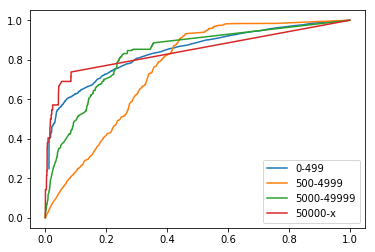

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def get_xy(probs, val):
    cutoffs = pd.DataFrame({"cutoff": np.unique(probs)})
    cutoffs = cutoffs.sort_values("cutoff")
    tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], val.y == 1)) / np.sum(val.y == 1), axis=1)
    fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut[0], val.y == 0)) / np.sum(val.y == 0), axis=1)
    stats = pd.DataFrame({'cutoff':cutoffs.cutoff, 'tpr':tpr, 'fpr':fpr})
    return stats['fpr'].values,stats['tpr'].values


for column, category in zip(gs.predict_proba(X_test).T,gs.classes_):
    val = pd.DataFrame()
    val['y'] = pd.Series(y_test).apply(lambda x: x==category)
    x, y = get_xy(column, val)
    plt.plot(x,y, label=category)
plt.legend()
plt.savefig("auc_plot")